# UNCC Building Recognition Modeling

**Note: It is recommended to have 8GB of ram on your system to run this code. If you have less, it is recommended to decrease the size of the images to 64x64**



In [1]:
#Imports needed for modeling

import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from sklearn import svm

In [2]:
%cd 4152_Building_Pictures/new_data

e:\Group2CompVisProject\4152_Building_Pictures\new_data


In [3]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[8:] for name in glob.glob('./train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):    
    data = []
    labels = []    
    channel_num = 3 if is_color else 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)
            
   
    # Data Augmentation 
    if augment: 
        
      augment = []

      for img in data:
        img_flip = np.fliplr(img)
        augment.append(img_flip)

      data = data + augment  
      labels = labels + labels


    # Data Normalization
    if zero_centered:
        
      mean = np.mean(data, axis=0)
      for idx, img in enumerate(data):
        data[idx] = img - mean

         
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []
        
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
           
        
        data, labels = batch_data, batch_labels 
        
    
    return zip(batch_data, batch_labels)

class_names: {0: '12 - Smith', 1: '17 - Belk Gym', 2: '32 - Colvard', 3: '34 - Prospector', 4: '38 - Burson', 5: '4 - Atkins', 6: '46 - SAC', 7: '52 - Cato', 8: '56 - Woodward', 9: '63 - CHHS', 10: '69 - Student Union', 11: '96 - UREC'} 


## Training Function Definition

Loss Function: Cross Entropy Loss


In [4]:
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)

## Evaluation Function Definition

In [5]:
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))

## Load + Display Example Image + Label

In [6]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 32 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, 
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./val/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 48 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 10 minibatches (batch_size=32) of testing samples.


4 - Atkins


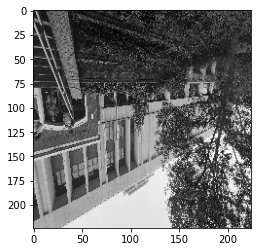

In [7]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_large[0][0][11][0], trainloader_large[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

# Experiments
In order to find the best model for our data, we tested multiple models and techniques to increase accuracy. Before covering the model that we decided to go with, models and ideas that were tested and ultimatly not used will first be reviewed.

The following is what we tried but ultimatly decided not to go with:
* Using Pretrained GoogleNet as our model
* Using Pretrained VGG Net as our model
* Using Vision Transformers with ResNet50 backbone and Self Attention
* Creating and training a CNN from scratch
* Running the data through our model without any Zero Centering or Augmentations

Universal Dataset information: train, test split: 80% / 20%

Note on why validation split is not used: Different hyperparameters were tried and then the model was reset to test its accuracy. Therefore, test data was sufficient for our purpose.

### Experiment 1: Using Pretrained GoogleNet as our model

In our research, we found that there are multiple pretrained models that could be used with our dataset. In order to find the best one for our data, we ran through multiple different models to gauge the one that would work best for us. To start, we used GoogleNet as our pretrained model. 
* Hyperparameters
    * Learning Rate: 0.0001
    * Number of epochs: 15
* Image Size: (224 x 224)
* Data Agmentation: Horizonal Flip
* Data Normalization: Zero Centered
* Library and tools used: Pytorch, Torch Vision, Torch, GoogleNet pre-trained model.


Accuracy: Around 75%

In [12]:
# define pretrainned googlenet model
google_net = torchvision.models.googlenet(pretrained = True)
google_net.fc = nn.Linear(1024, 12)

c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------

train_option={}
train_option['lr'] = 0.0001
train_option['epoch'] = 15
train_option['device'] = 'gpu'

trainModel(google_net, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.5408 | Average Loss: 2.5408 
Epoch: 1 | Iter:   20 | Time: 00:00:02 | Train Loss: 2.0444 | Average Loss: 2.2648 
Accuracy: 0.496875 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:03 | Train Loss: 1.5214 | Average Loss: 2.1946 
Epoch: 2 | Iter:   20 | Time: 00:00:06 | Train Loss: 1.2952 | Average Loss: 1.8548 
Accuracy: 0.612500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:07 | Train Loss: 1.0921 | Average Loss: 1.8027 
Epoch: 3 | Iter:   20 | Time: 00:00:09 | Train Loss: 0.7900 | Average Loss: 1.5392 
Accuracy: 0.693750 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:10 | Train Loss: 0.7542 | Average Loss: 1.4959 
Epoch: 4 | Iter:   20 | Time: 00:00:12 | Train Loss: 0.4233 | Average Loss: 1.2889 
Accuracy: 0.743750 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:13 | Train Loss: 0.4817 | Average Loss: 1.2541 
Epoch: 5 | Iter:   20 | Time: 00:00:15 | Train Loss: 0.2535 | Average Loss: 1.0921 
Accuracy: 0.7531

### Experiment 2: Using Pretrained VGG Net as our model
Continuing with testing different pre-trained CNN models, in this experiment we implement the vgg16 pretrained model.
* Hyperparameters
    * Learning Rate: 0.0001
    * Number of epochs: 15
* Image Size: (224 x 224)
* Data Agmentation: Horizonal Flip
* Data Normalization: Zero Centered
* Library and tools used: Pytorch, Torch Vision, Torch, VGG16 pre-trained model.


Accuracy: Around 70%

In [9]:
# define pretrainned vgg model
vgg_net = torchvision.models.vgg16(pretrained = True)
vgg_net.classifier[6] = nn.Linear(4096, 12)

c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
train_option={}
train_option['lr'] = 0.0001
train_option['epoch'] = 15
train_option['device'] = 'gpu'

trainModel(vgg_net, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:04 | Train Loss: 2.6067 | Average Loss: 2.6067 
Epoch: 1 | Iter:   20 | Time: 00:00:09 | Train Loss: 1.7096 | Average Loss: 2.0222 
Accuracy: 0.521875 | Time: 00:00:01
Epoch: 2 | Iter:    0 | Time: 00:00:12 | Train Loss: 1.2688 | Average Loss: 1.9327 
Epoch: 2 | Iter:   20 | Time: 00:00:20 | Train Loss: 0.6696 | Average Loss: 1.4917 
Accuracy: 0.715625 | Time: 00:00:01
Epoch: 3 | Iter:    0 | Time: 00:00:23 | Train Loss: 0.4419 | Average Loss: 1.4102 
Epoch: 3 | Iter:   20 | Time: 00:00:30 | Train Loss: 0.4916 | Average Loss: 1.1083 
Accuracy: 0.734375 | Time: 00:00:01
Epoch: 4 | Iter:    0 | Time: 00:00:33 | Train Loss: 0.2107 | Average Loss: 1.0610 
Epoch: 4 | Iter:   20 | Time: 00:00:41 | Train Loss: 0.2168 | Average Loss: 0.8768 
Accuracy: 0.693750 | Time: 00:00:01
Epoch: 5 | Iter:    0 | Time: 00:00:43 | Train Loss: 0.2177 | Average Loss: 0.8502 
Epoch: 5 | Iter:   20 | Time: 00:00:51 | Train Loss: 0.1372 | Average Loss: 0.7291 
Accuracy: 0.6531

### Experiment 3: Using Vision Transformers with ResNet50 backbone and Self Attention
Suggested by the professor, we tried implementing a self-attention/Vision transformer proccess alongside the ResNet50 pretrained network.
* Hyperparameters
    * Learning Rate: 0.0001
    * Number of epochs: 15
* Image Size: (96 x 96)
* Data Agmentation: Horizonal Flip
* Data Normalization: Zero Centered
* Library and tools used: Pytorch, Torch Vision, Torch, ResNet50 with vision transforming pre-trained model.

Accuracy: Around 50%

In [6]:
# reload data with a larger size
img_size = (96, 96)
batch_size = 32 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, 
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./val/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 48 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 10 minibatches (batch_size=32) of testing samples.


In [7]:
from self_attention_cv import ResNet50ViT
vit_net = ResNet50ViT(img_dim = 96, pretrained_resnet=True, num_classes=12)

train_option={}
train_option['lr'] = 0.00005
train_option['epoch'] = 15
train_option['device'] = 'gpu'

trainModel(vit_net, trainloader_large, train_option, testloader_large)

c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 | Iter:    0 | Time: 00:00:04 | Train Loss: 2.4238 | Average Loss: 2.4238 
Epoch: 1 | Iter:   20 | Time: 00:00:07 | Train Loss: 2.3656 | Average Loss: 2.3742 
Epoch: 1 | Iter:   40 | Time: 00:00:11 | Train Loss: 2.2019 | Average Loss: 2.3699 
Accuracy: 0.153125 | Time: 00:00:01
Epoch: 2 | Iter:    0 | Time: 00:00:14 | Train Loss: 2.0167 | Average Loss: 2.3481 
Epoch: 2 | Iter:   20 | Time: 00:00:19 | Train Loss: 2.1215 | Average Loss: 2.3098 
Epoch: 2 | Iter:   40 | Time: 00:00:24 | Train Loss: 2.0444 | Average Loss: 2.2841 
Accuracy: 0.243750 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:26 | Train Loss: 1.6550 | Average Loss: 2.2608 
Epoch: 3 | Iter:   20 | Time: 00:00:31 | Train Loss: 1.8567 | Average Loss: 2.2228 
Epoch: 3 | Iter:   40 | Time: 00:00:36 | Train Loss: 1.8282 | Average Loss: 2.1858 
Accuracy: 0.325000 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:39 | Train Loss: 1.2947 | Average Loss: 2.1652 
Epoch: 4 | Iter:   20 | Time: 00:00:43 | Train Loss:

### Experiment 4: Creating and training a CNN from scratch
Through our researh, we were aware that a pre-trained model with more layers would server more affective than a CNN model from scratch. However, we implemented a CNN model from scratch to double confirm our intuition.
* Hyperparameters
    * Learning Rate: 0.0001
    * Number of epochs: 20
* Image Size: (64 x 64)
* Data Agmentation: Horizonal Flip
* Data Normalization: Zero Centered
* Library and tools used: Pytorch, Torch Vision, Torch.

Accuracy: Around 50%

In [24]:
# reload data with a larger size
img_size = (64, 64)
batch_size = 32 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, 
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./val/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 48 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 10 minibatches (batch_size=32) of testing samples.


In [25]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4, stride=4),
        nn.Dropout(0.5)
      )
      
      self.classifier = nn.Sequential(
        nn.Linear(16*8*8, 16),
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x 
      

In [26]:
conv2d_net = TNet()

In [28]:
train_option={}
train_option['lr'] = 0.001
train_option['epoch'] = 20
train_option['device'] = 'gpu'

trainModel(conv2d_net, trainloader_large, train_option, testloader_large)


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.6485 | Average Loss: 0.6485 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 0.3866 | Average Loss: 0.8300 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 0.7955 | Average Loss: 0.7825 
Accuracy: 0.478125 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 0.6563 | Average Loss: 0.7931 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 0.6037 | Average Loss: 0.7848 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 0.5935 | Average Loss: 0.7702 
Accuracy: 0.528125 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.5645 | Average Loss: 0.7696 
Epoch: 3 | Iter:   20 | Time: 00:00:01 | Train Loss: 0.6126 | Average Loss: 0.7609 
Epoch: 3 | Iter:   40 | Time: 00:00:01 | Train Loss: 0.5688 | Average Loss: 0.7462 
Accuracy: 0.484375 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:01 | Train Loss: 0.9066 | Average Loss: 0.7496 
Epoch: 4 | Iter:   20 | Time: 00:00:01 | Train Loss:

### Experiment 5: Running the data through our model without any Zero Centering or Augmentations
In this experiment, we tried using a different pre-trained architure, ResNet50, without any data augmentation.
* Hypterparamters
    * Learning Rate: 0.0001
    * Number of epochs: 15
* Image Size: (224 x 224)
* Data Agmentation: None
* Data Normalization: None
* Library and tools used: Pytorch, Torch Vision, Torch, ResNet50 pre-trained model.

Accuracy: Around 85%

Note: Although the results seem very similar to the the final model with data augmentation, it's important to implement augmentaion for potentially better generalization to avoid overfitting to the training dataset.

In [29]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 32 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=False))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./val/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=False))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 24 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 10 minibatches (batch_size=32) of testing samples.


In [ ]:
model = torchvision.models.resnet50(pretrained = True)
model.fc = nn.Linear(2048, 12)

In [30]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------

train_option={}
train_option['lr'] = 0.0001
train_option['epoch'] = 15
train_option['device'] = 'gpu'

trainModel(model, trainloader_large, train_option, testloader_large)

c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.5257 | Average Loss: 2.5257 
Epoch: 1 | Iter:   20 | Time: 00:00:06 | Train Loss: 0.9914 | Average Loss: 1.6950 
Accuracy: 0.753125 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:07 | Train Loss: 0.5551 | Average Loss: 1.5556 
Epoch: 2 | Iter:   20 | Time: 00:00:12 | Train Loss: 0.1231 | Average Loss: 1.0073 
Accuracy: 0.853125 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:13 | Train Loss: 0.0678 | Average Loss: 0.9329 
Epoch: 3 | Iter:   20 | Time: 00:00:17 | Train Loss: 0.0234 | Average Loss: 0.6765 
Accuracy: 0.871875 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:19 | Train Loss: 0.0155 | Average Loss: 0.6403 
Epoch: 4 | Iter:   20 | Time: 00:00:22 | Train Loss: 0.0109 | Average Loss: 0.5058 
Accuracy: 0.878125 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:24 | Train Loss: 0.0083 | Average Loss: 0.4853 
Epoch: 5 | Iter:   20 | Time: 00:00:28 | Train Loss: 0.0071 | Average Loss: 0.4037 
Accuracy: 0.8750

## Experiment Results:

As a reminder the following were the experiments conducted:
* Experiment 1: Using Pretrained GoogleNet as our model
* Experiment 2: Using Pretrained VGG Net as our model
* Experiment 3: Using Vision Transformers with ResNet50 backbone and Self Attention
* Experiment 4: Creating and training a CNN from scratch
* Experiment 5: Running the data through our model without any Zero Centering or Augmentations

All experiments performed well, however not as well as the final model that we chose.


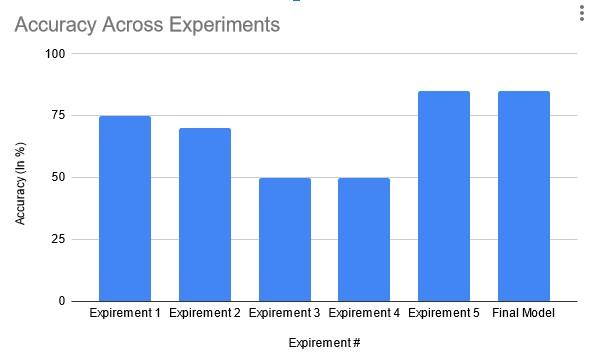

# The Final Model

## Literature Review

The motivation behind our approach of using a pre-trained neural network for modeling image classification for the UNCC building comes from an article regarding building recognition, ”Building recognition system based on deep learning” by Pavol Bezak. The author has similar conditions for collecting building information and modeling it to predict buildings. For the data collection, our group had to hand-collect pictures of the respective UNCC buildings identical to the author who takes images of historic buildings in the town of Trnava. 

The article discusses how real-life conditions make building recognition often a complex problem. The varying lighting, angle, and resolution are often major factors contributing to the complexity of building recognition. To tackle building recognition, a deep learning architecture is best put to use compared to other approaches such as handcrafted features. Combining low-level features to create high-level representations of the buildings. Determining these features allows for understanding the characteristics of different buildings. Compared to handcrafted features that aren’t suited for high-dimensional sets of image features. 

To implement a neural network to classify the buildings, a CNN-based approach allowed for automatic high-dimensional feature extraction. Resulting in a great performance with a relatively small dataset. The model was able to detect the images of building to recognize historic buildings with high accuracy.

The goal of this project lines up well with the author’s goal of building classification with a relatively small dataset. Hence, we steered towards a CNN-based classification approach for our project rather than using hand-crafted features. We implemented a pre-trained CNN approach for our modeling our data. However, compared to the author we aren’t as bottlenecked by computing power. Therefore, we increased the image size and used various other heavy-weight pre-trained networks compared to the author’s 28x28 image size that was fed into a lightweight LeNet.

## Model Description
The model uses a tuned pre-trained ResNet50 Architecture with the last fully connected layer trained with our dataset containing pictures of UNCC buildings. The loss function utilized is cross-entropy loss for multiclass image classification. 

In [6]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 32 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./train/', img_size, num_per_class=100, batch_size=batch_size, shuffle=True, 
                                      augment=True, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./val/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 48 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Finish loading 10 minibatches (batch_size=32) of testing samples.


In [7]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------

train_option={}
train_option['lr'] = 0.0001
train_option['epoch'] = 15
train_option['device'] = 'gpu'

model = torchvision.models.resnet50(pretrained = True)

model.fc = nn.Linear(2048, 12)

trainModel(model, trainloader_large, train_option, testloader_large)

c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nathan\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1 | Iter:    0 | Time: 00:00:04 | Train Loss: 2.4308 | Average Loss: 2.4308 
Epoch: 1 | Iter:   20 | Time: 00:00:07 | Train Loss: 1.2069 | Average Loss: 1.7808 
Epoch: 1 | Iter:   40 | Time: 00:00:10 | Train Loss: 0.5769 | Average Loss: 1.3653 
Accuracy: 0.800000 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:12 | Train Loss: 0.2033 | Average Loss: 1.2173 
Epoch: 2 | Iter:   20 | Time: 00:00:15 | Train Loss: 0.1135 | Average Loss: 0.9191 
Epoch: 2 | Iter:   40 | Time: 00:00:18 | Train Loss: 0.0738 | Average Loss: 0.7317 
Accuracy: 0.837500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:20 | Train Loss: 0.0244 | Average Loss: 0.6746 
Epoch: 3 | Iter:   20 | Time: 00:00:23 | Train Loss: 0.0230 | Average Loss: 0.5633 
Epoch: 3 | Iter:   40 | Time: 00:00:26 | Train Loss: 0.0094 | Average Loss: 0.4834 
Accuracy: 0.859375 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:28 | Train Loss: 0.0072 | Average Loss: 0.4572 
Epoch: 4 | Iter:   20 | Time: 00:00:31 | Train Loss:

# Model Architecture

The model.eval() command listed below displays the architecture for our model

In [10]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Using model to predict

Below is an example that uses our model to predict the building given a picture. In this case we fed the model an image of Prospector.

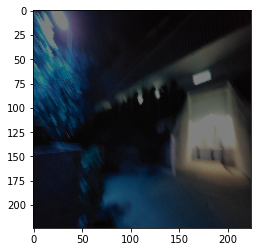

Prediction:  17 - Belk Gym


In [22]:
#Input an image and get a prediction of the class
def img_load(file_path):
    
    img = cv2.imread(file_path)
    img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
    img = np.transpose(img, [2, 0, 1])
    return img.astype(np.float)/(255*2-1)

# show some images
def displayimg(img):
     # unnormalize
    if len(img.shape) > 2:
        img = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(img, 'gray')
    plt.show()


def predict(net, img, device='gpu'):
    net.eval()
    if device == 'gpu':
        net = net.cuda()
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = Variable(img).float()
    if device == 'gpu':
        img = img.cuda()
    outputs = net(img)
    return outputs.max(1)[1].item()

def convert_label(label):
    return class_names[label]

# CHANGE THE IMAGE PATH HERE TO TEST YOUR OWN IMAGE
img = img_load('./val/17 - Belk Gym/Belk (84).jpg')

prediction = (predict(model, img))
displayimg(img)
print("Prediction: ", convert_label(prediction))


